# HR Analytics 

The objective of this study is to investigate employee, action and performance data and focus on the following HR Metrics:<ul><br>- diversity metrics <br>- employee turnover <br>- employee engagement index and employee satisfaction </ul>

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use('ggplot')

from sklearn.linear_model import LinearRegression
import statsmodels.api as sm

from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_blobs
from sklearn.metrics import silhouette_score

<b>Step 1: Upload HR dataset files

In [2]:
hr=pd.read_csv('HR Data.csv')
action=pd.read_csv('tbl_Action.csv')
employee=pd.read_csv('tbl_Employee.csv')
performance=pd.read_csv('tbl_Perf.csv')

### Part I  - Data wrangling

<b>Step 2: Check for nulls on Action and performance dataframe.

In [3]:
action.head()

,ActID,ActionID,EmpID,EffectiveDt
0,1,10,1,01/Jan/2015
1,2,10,2,01/Jan/2015
2,3,10,3,06/Oct/2015
3,4,10,4,01/Jan/2015
4,5,10,5,22/May/2015


In [4]:
action.isnull().sum()

ActID          0
ActionID       0
EmpID          0
EffectiveDt    0
dtype: int64

In [5]:
performance.head()

,PerfID,EmpID,Rating,PerfDate
0,1,1,1,31/Dec/2015
1,2,2,2,31/Dec/2015
2,3,3,2,31/Dec/2015
3,4,4,4,31/Dec/2015
4,5,5,2,31/Dec/2015


In [6]:
performance.isnull().sum()

PerfID      0
EmpID       0
Rating      0
PerfDate    0
dtype: int64

<b>Step 3: Check employee dataframe.   

In [7]:
employee.head()

,EmpID,EmpName,EngDt,TermDt,DepID,GenderID,RaceID,MgrID,DOB,PayRate,Level
0,1,"Nash, Kay K",1/1/15,29-May-17,8,1,1,1,12-Feb-87,NaN,1
1,2,"Simpson, Raymond X",1/1/15,NaN,7,0,4,2,15-Nov-82,NaN,1
2,3,"Devlin, Kay M",6/10/15,24-Jun-19,10,1,5,3,22-Feb-86,NaN,1
3,4,"Massie, Elisabeth V",1/1/15,NaN,4,1,2,4,25-May-77,NaN,1
4,5,"Mead, Catherine N",22/5/15,15-Jul-20,8,1,1,1,4-Apr-95,NaN,2


In [8]:
employee.shape

(1562, 11)

<b>Step 4: The employee table needs cleaning, it has null values at TermDT and PayRate column.

In [9]:
employee.isnull().sum()

EmpID          0
EmpName        0
EngDt          0
TermDt      1118
DepID          0
GenderID       0
RaceID         0
MgrID          0
DOB            0
PayRate     1562
Level          0
dtype: int64

NaN on the TermDt column means that the employee is currently working, so we will replace NaN with the current date. 

In [10]:
from datetime import date
today=date.today()

In [11]:
employee['TermDt'].fillna(today, inplace=True)
employee['TermDt'].value_counts()

2021-03-15    1118
11-Aug-22        3
15-Jun-22        3
27-May-21        2
22-Aug-18        2
              ... 
19-Apr-16        1
26-Mar-18        1
8-Sep-23         1
29-Apr-16        1
16-Apr-18        1
Name: TermDt, Length: 414, dtype: int64

<b>Step 5: PayRate column is empty. It is safe to delete that column. 

In [12]:
employee.drop(['PayRate'],axis=1,inplace=True)

In [13]:
employee.head()

,EmpID,EmpName,EngDt,TermDt,DepID,GenderID,RaceID,MgrID,DOB,Level
0,1,"Nash, Kay K",1/1/15,29-May-17,8,1,1,1,12-Feb-87,1
1,2,"Simpson, Raymond X",1/1/15,2021-03-15,7,0,4,2,15-Nov-82,1
2,3,"Devlin, Kay M",6/10/15,24-Jun-19,10,1,5,3,22-Feb-86,1
3,4,"Massie, Elisabeth V",1/1/15,2021-03-15,4,1,2,4,25-May-77,1
4,5,"Mead, Catherine N",22/5/15,15-Jul-20,8,1,1,1,4-Apr-95,2


<b> Step 6: Check for duplicate rows in employee dataframe

In [14]:
employee['EmpName'].value_counts()

Colley, Selina K      2
Gibbs, Joanne V       2
Coombs, Jane O        1
Hardy, Alan I         1
Colley, Iris W        1
                     ..
Ewart, Helen F        1
Jarvis, Daniel K      1
Shelley, Leigh D      1
Smith, Gwendolyn S    1
Rawson, Judy U        1
Name: EmpName, Length: 1560, dtype: int64

In [15]:
employee[employee['EmpName']=='Gibbs, Joanne V']

,EmpID,EmpName,EngDt,TermDt,DepID,GenderID,RaceID,MgrID,DOB,Level
449,450,"Gibbs, Joanne V",8/10/16,2021-03-15,1,1,5,394,13-Oct-96,11
733,734,"Gibbs, Joanne V",1/1/15,18-Jul-19,1,1,5,724,30-Sep-94,17


In [16]:
employee[employee['EmpName']=='Colley, Selina K']

,EmpID,EmpName,EngDt,TermDt,DepID,GenderID,RaceID,MgrID,DOB,Level
126,127,"Colley, Selina K",10/3/16,2021-03-15,5,1,3,100,1-Mar-77,3
230,231,"Colley, Selina K",29/5/16,2021-03-15,4,1,3,188,25-Mar-80,5


Employees with duplicate names are different persons as indicated on their date of birth.

<b> Step 7: Check HR dataframe to see if there are any NaNs.

In [17]:
hr.head()

,Employee_Name,EmpID,MarriedID,MaritalStatusID,GenderID,EmpStatusID,DeptID,PerfScoreID,FromDiversityJobFairID,PayRate,...,ManagerName,ManagerID,RecruitmentSource,PerformanceScore,EngagementSurvey,EmpSatisfaction,SpecialProjectsCount,LastPerformanceReview_Date,DaysLateLast30,Original DS
0,"Gonzalez, Maria",1988299991,0,3,0,1,3,3,0,39.0,...,Peter Monroe,7.0,Employee Referral,Fully Meets,4.61,4,5,28/1/19,0.0,Orig
1,"Cockel, James",1599991009,0,0,1,1,5,3,0,15.0,...,David Stanley,14.0,Employee Referral,Fully Meets,1.51,5,0,14/1/19,0.0,Orig
2,"Bunbury, Jessica",1504073368,1,1,0,5,6,3,0,55.0,...,John Smith,17.0,Social Networks - Facebook Twitter etc,Fully Meets,3.14,5,0,NaN,NaN,Orig
3,"Buck, Edward",1504073313,1,1,1,1,6,3,0,55.0,...,Lynn Daneault,21.0,Employee Referral,Fully Meets,3.31,5,0,28/1/19,0.0,Orig
4,"Jacobi, Hannah",1503072857,0,2,0,1,5,3,0,21.0,...,Kissy Sullivan,20.0,Employee Referral,Fully Meets,2.05,5,0,22/2/19,0.0,Orig


In [18]:
hr.shape

(3310, 37)

In [19]:
hr.isnull().sum()

Employee_Name                    0
EmpID                            0
MarriedID                        0
MaritalStatusID                  0
GenderID                         0
EmpStatusID                      0
DeptID                           0
PerfScoreID                      0
FromDiversityJobFairID           0
PayRate                          0
Termd                            0
PositionID                       0
Position                         0
State                            0
Zip                           3000
DOB                              0
Sex                              0
MaritalDesc                      0
CitizenDesc                      0
HispanicLatino                   0
RaceDesc                         0
DateofHire                       0
DateofTermination             2351
TermReason                      11
EmploymentStatus                 0
EmpTotal                         0
Department                       0
ManagerName                     78
ManagerID           

HR dataframe has nulls on the Zip, DateofTermination, TermReason, ManagerName, ManagerID, LastPerformanceReview_Date and DaysLateLast30. <br>Steps taken: <ul> - Accept NaNs for DaysLateLast30 because it signifies that the employee did not have any late days during the last 30 days <br> - Accept NaNs for the LastPerformanceReview_Date because the employee has not had a performance review <br> - Accept NaNs for ManagerID and ManagerName because employee is working independently. <br> - Accept NaNs in the Zip column

<b> Step 8: NaNs on the DateofTermination column means that the employee is currently working, replace NaNs with the current date.

In [20]:
hr['DateofTermination'].fillna(today, inplace=True)
hr['DateofTermination'].value_counts()

2021-03-15    2351
1/5/16          33
25/5/16         33
12/9/15         26
17/5/14         25
              ... 
12/5/15          1
5/9/15           1
18/2/13          1
2/1/12           1
29/4/18          1
Name: DateofTermination, Length: 105, dtype: int64

<b> Step 9: There are 11 NaNs on TermReason column

In [21]:
hr['TermReason'].value_counts()

N/A - still employed                2212
Another position                     181
unhappy                              161
more money                           119
hours                                113
N/A - Has not started yet             85
relocation out of area                63
career change                         59
retiring                              54
military                              53
return to school                      46
performance                           45
attendance                            42
medical issues                        28
no-call, no-show                      20
maternity leave - did not return      15
gross misconduct                       3
Name: TermReason, dtype: int64

Check for patterns in the data why the TermReason is null.

In [22]:
hr[hr ['TermReason'].isnull()][['Termd','DateofTermination','EmploymentStatus','TermReason']]

,Termd,DateofTermination,EmploymentStatus,TermReason
131,1,15/4/15,Terminated for Cause,NaN
516,1,2021-03-15,Active,NaN
826,1,2021-03-15,Active,NaN
1136,1,2021-03-15,Active,NaN
1446,1,2021-03-15,Active,NaN
1756,1,2021-03-15,Active,NaN
2066,1,2021-03-15,Active,NaN
2376,1,2021-03-15,Active,NaN
2686,1,2021-03-15,Active,NaN
2996,1,2021-03-15,Active,NaN


<b>Step 10: Replace TermReason to N/A - still employed for the 10 Active employees with TermReason as NaN. 

In [23]:
hr.loc[(hr['EmploymentStatus'] == 'Active') & (hr['TermReason'].isnull()),'TermReason'] = 'N/A - still employed'

Checking our work:

In [24]:
hr[hr ['TermReason'].isnull()][['Termd','DateofTermination','EmploymentStatus','TermReason']]

,Termd,DateofTermination,EmploymentStatus,TermReason
131,1,15/4/15,Terminated for Cause,NaN


<b> Step 11: Replace remaining Nan with TermReason as 'for cause'.

In [25]:
hr.loc[(hr['EmploymentStatus'] == 'Terminated for Cause') & (hr['TermReason'].isnull()),'TermReason'] = 'for cause'

Checking our work:

In [26]:
hr['TermReason'].value_counts()

N/A - still employed                2222
Another position                     181
unhappy                              161
more money                           119
hours                                113
N/A - Has not started yet             85
relocation out of area                63
career change                         59
retiring                              54
military                              53
return to school                      46
performance                           45
attendance                            42
medical issues                        28
no-call, no-show                      20
maternity leave - did not return      15
gross misconduct                       3
for cause                              1
Name: TermReason, dtype: int64

<b> Step 12: Check for duplicate row values 

In [27]:
hr['Employee_Name'].value_counts()

Young, Darien        2
Warner, Larissa      2
Terrell, Tatum       1
Cooley, Alani        1
Sheppard, Sadie      1
                    ..
Nowlan, Kristie      1
Odom, Kaylynn        1
Mathis, Kyleigh      1
Mcdonald, Ricardo    1
Patton, Eleanor      1
Name: Employee_Name, Length: 3308, dtype: int64

Checking if they are the same person:

In [28]:
hr[hr['Employee_Name']=='Warner, Larissa']

,Employee_Name,EmpID,MarriedID,MaritalStatusID,GenderID,EmpStatusID,DeptID,PerfScoreID,FromDiversityJobFairID,PayRate,...,ManagerName,ManagerID,RecruitmentSource,PerformanceScore,EngagementSurvey,EmpSatisfaction,SpecialProjectsCount,LastPerformanceReview_Date,DaysLateLast30,Original DS
2758,"Warner, Larissa",9024100552,1,1,0,1,5,3,0,26.0,...,Elijiah Gray,16.0,Newspager/Magazine,Fully Meets,1.49,5,0,NaN,NaN,New
2910,"Warner, Larissa",9001310400,0,0,0,1,5,3,0,16.0,...,Amy Dunn,11.0,Word of Mouth,Fully Meets,2.00,4,0,NaN,NaN,New


In [29]:
hr[hr['Employee_Name']=='Young, Darien']

,Employee_Name,EmpID,MarriedID,MaritalStatusID,GenderID,EmpStatusID,DeptID,PerfScoreID,FromDiversityJobFairID,PayRate,...,ManagerName,ManagerID,RecruitmentSource,PerformanceScore,EngagementSurvey,EmpSatisfaction,SpecialProjectsCount,LastPerformanceReview_Date,DaysLateLast30,Original DS
1133,"Young, Darien",9071302177,0,0,0,1,6,3,0,55.0,...,John Smith,17.0,Website Banner Ads,Fully Meets,3.60,5,0,NaN,NaN,New
1992,"Young, Darien",9049431318,0,2,0,4,5,2,0,51.0,...,Janet King,2.0,Search Engine - Google Bing Yahoo,Needs Improvement,4.78,4,0,NaN,NaN,New


It seems that those employees are different persons (as indicated by their EmpID), so duplicate rows will be accepted. 

### Part II - Merge dataframes

Data from Action, Employee, and Performance dataframe needs to be merged. 

<b> Step 1: Check several last rows for 3 dataframes.

In [30]:
action.tail()

,ActID,ActionID,EmpID,EffectiveDt
2581,2582,30,869,16/May/2023
2582,2583,30,1024,17/Aug/2023
2583,2584,30,1220,10/Aug/2023
2584,2585,30,1279,24/Mar/2023
2585,2586,30,1329,23/May/2023


In [31]:
employee.tail()

,EmpID,EmpName,EngDt,TermDt,DepID,GenderID,RaceID,MgrID,DOB,Level
1557,1558,"Shearer, Dimitrios Q",1/11/23,2021-03-15,3,0,1,1526,21-May-90,28
1558,1559,"Shute, Phyllis H",12/7/23,2021-03-15,1,1,1,1460,1-Oct-74,30
1559,1560,"Scholes, Ripduman K",22/4/23,2021-03-15,1,1,4,1559,11-May-71,31
1560,1561,"Rawson, Elisabeth K",7/3/23,2021-03-15,6,1,3,1554,25-Aug-82,30
1561,1562,"Mongan, Gabriele T",1/7/23,2021-03-15,2,1,5,1530,15-Nov-74,26


In [32]:
performance.tail()

,PerfID,EmpID,Rating,PerfDate
9600,9601,1558,3,31/Dec/2023
9601,9602,1559,2,31/Dec/2023
9602,9603,1560,4,31/Dec/2023
9603,9604,1561,2,31/Dec/2023
9604,9605,1562,2,31/Dec/2023


<b> Step 2: Join first 2 dataframes (employee and performance) and then merge third dataframe (action). 

In [33]:
df1=employee.merge(performance, how='inner', on='EmpID')

In [34]:
combined_df=df1.merge(action,how='inner', on='EmpID')

<b> Step 3: Check shape and heads of combined dataframe

In [35]:
combined_df.head()

,EmpID,EmpName,EngDt,TermDt,DepID,GenderID,RaceID,MgrID,DOB,Level,PerfID,Rating,PerfDate,ActID,ActionID,EffectiveDt
0,1,"Nash, Kay K",1/1/15,29-May-17,8,1,1,1,12-Feb-87,1,1,1,31/Dec/2015,1,10,01/Jan/2015
1,1,"Nash, Kay K",1/1/15,29-May-17,8,1,1,1,12-Feb-87,1,1,1,31/Dec/2015,1209,91,29/May/2017
2,1,"Nash, Kay K",1/1/15,29-May-17,8,1,1,1,12-Feb-87,1,869,4,31/Dec/2016,1,10,01/Jan/2015
3,1,"Nash, Kay K",1/1/15,29-May-17,8,1,1,1,12-Feb-87,1,869,4,31/Dec/2016,1209,91,29/May/2017
4,2,"Simpson, Raymond X",1/1/15,2021-03-15,7,0,4,2,15-Nov-82,1,2,2,31/Dec/2015,2,10,01/Jan/2015


In [36]:
combined_df.shape

(14332, 16)

In [37]:
combined_df.isnull().sum()

EmpID          0
EmpName        0
EngDt          0
TermDt         0
DepID          0
GenderID       0
RaceID         0
MgrID          0
DOB            0
Level          0
PerfID         0
Rating         0
PerfDate       0
ActID          0
ActionID       0
EffectiveDt    0
dtype: int64

In [38]:
combined_df['EmpID'].value_counts()

152     63
292     56
264     48
247     48
157     48
        ..
1507     1
1515     1
1523     1
1531     1
1539     1
Name: EmpID, Length: 1532, dtype: int64

In [39]:
combined_df[combined_df['EmpID']== 152]

,EmpID,EmpName,EngDt,TermDt,DepID,GenderID,RaceID,MgrID,DOB,Level,PerfID,Rating,PerfDate,ActID,ActionID,EffectiveDt
1591,152,"Murray, Thomas K",12/3/15,10-Feb-24,9,0,3,146,10-May-65,4,136,4,31/Dec/2015,152,10,12/Mar/2015
1592,152,"Murray, Thomas K",12/3/15,10-Feb-24,9,0,3,146,10-May-65,4,136,4,31/Dec/2015,1837,91,04/Oct/2022
1593,152,"Murray, Thomas K",12/3/15,10-Feb-24,9,0,3,146,10-May-65,4,136,4,31/Dec/2015,1967,91,10/Feb/2024
1594,152,"Murray, Thomas K",12/3/15,10-Feb-24,9,0,3,146,10-May-65,4,136,4,31/Dec/2015,2109,30,19/Jun/2017
1595,152,"Murray, Thomas K",12/3/15,10-Feb-24,9,0,3,146,10-May-65,4,136,4,31/Dec/2015,2467,30,25/Jun/2020
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1649,152,"Murray, Thomas K",12/3/15,10-Feb-24,9,0,3,146,10-May-65,4,8592,3,31/Dec/2023,1967,91,10/Feb/2024
1650,152,"Murray, Thomas K",12/3/15,10-Feb-24,9,0,3,146,10-May-65,4,8592,3,31/Dec/2023,2109,30,19/Jun/2017
1651,152,"Murray, Thomas K",12/3/15,10-Feb-24,9,0,3,146,10-May-65,4,8592,3,31/Dec/2023,2467,30,25/Jun/2020
1652,152,"Murray, Thomas K",12/3/15,10-Feb-24,9,0,3,146,10-May-65,4,8592,3,31/Dec/2023,2527,30,05/Mar/2021


### Part III - Prepare data for analysis 

<b> Step 1: Check datatypes for HR dataframe.</b> <br>The following needs to be converted: <br> - DateofHire into datetime64 <br> - LastPerformance ReviewDate into datetime64 <br> - DateofTErmination into datetime64

In [40]:
hr['DateofHire']=pd.to_datetime(hr['DateofHire'])

In [41]:
hr['LastPerformanceReview_Date']=pd.to_datetime(hr['LastPerformanceReview_Date'])

In [42]:
hr['DateofTermination']=pd.to_datetime(hr['DateofTermination'])

In [43]:
print(hr.dtypes,'\n')

Employee_Name                         object
EmpID                                  int64
MarriedID                              int64
MaritalStatusID                        int64
GenderID                               int64
EmpStatusID                            int64
DeptID                                 int64
PerfScoreID                            int64
FromDiversityJobFairID                 int64
PayRate                              float64
Termd                                  int64
PositionID                             int64
Position                              object
State                                 object
Zip                                  float64
DOB                                   object
Sex                                   object
MaritalDesc                           object
CitizenDesc                           object
HispanicLatino                        object
RaceDesc                              object
DateofHire                    datetime64[ns]
DateofTerm

<b> Step 2: Check datatypes for HR dataframe.</b> <br>The following needs to be converted: <br> - EngDate into datetime64 <br> - PerfDate into datetime64 <br> - EffectiveDt into datetime64 <br> - TermDt into datetime64

In [44]:
combined_df['EngDt']=pd.to_datetime(combined_df['EngDt'])

In [45]:
combined_df['PerfDate']=pd.to_datetime(combined_df['PerfDate'])

In [46]:
combined_df['EffectiveDt']=pd.to_datetime(combined_df['EffectiveDt'])

In [47]:
combined_df['TermDt']=pd.to_datetime(combined_df['TermDt'])

In [48]:
print(combined_df.dtypes,'\n')

EmpID                   int64
EmpName                object
EngDt          datetime64[ns]
TermDt         datetime64[ns]
DepID                   int64
GenderID                int64
RaceID                  int64
MgrID                   int64
DOB                    object
Level                   int64
PerfID                  int64
Rating                  int64
PerfDate       datetime64[ns]
ActID                   int64
ActionID                int64
EffectiveDt    datetime64[ns]
dtype: object 



<b> Step 2: Check the dataframe heads. 

In [49]:
hr.head()

,Employee_Name,EmpID,MarriedID,MaritalStatusID,GenderID,EmpStatusID,DeptID,PerfScoreID,FromDiversityJobFairID,PayRate,...,ManagerName,ManagerID,RecruitmentSource,PerformanceScore,EngagementSurvey,EmpSatisfaction,SpecialProjectsCount,LastPerformanceReview_Date,DaysLateLast30,Original DS
0,"Gonzalez, Maria",1988299991,0,3,0,1,3,3,0,39.0,...,Peter Monroe,7.0,Employee Referral,Fully Meets,4.61,4,5,2019-01-28,0.0,Orig
1,"Cockel, James",1599991009,0,0,1,1,5,3,0,15.0,...,David Stanley,14.0,Employee Referral,Fully Meets,1.51,5,0,2019-01-14,0.0,Orig
2,"Bunbury, Jessica",1504073368,1,1,0,5,6,3,0,55.0,...,John Smith,17.0,Social Networks - Facebook Twitter etc,Fully Meets,3.14,5,0,NaT,NaN,Orig
3,"Buck, Edward",1504073313,1,1,1,1,6,3,0,55.0,...,Lynn Daneault,21.0,Employee Referral,Fully Meets,3.31,5,0,2019-01-28,0.0,Orig
4,"Jacobi, Hannah",1503072857,0,2,0,1,5,3,0,21.0,...,Kissy Sullivan,20.0,Employee Referral,Fully Meets,2.05,5,0,2019-02-22,0.0,Orig


In [50]:
combined_df.head()

,EmpID,EmpName,EngDt,TermDt,DepID,GenderID,RaceID,MgrID,DOB,Level,PerfID,Rating,PerfDate,ActID,ActionID,EffectiveDt
0,1,"Nash, Kay K",2015-01-01,2017-05-29,8,1,1,1,12-Feb-87,1,1,1,2015-12-31,1,10,2015-01-01
1,1,"Nash, Kay K",2015-01-01,2017-05-29,8,1,1,1,12-Feb-87,1,1,1,2015-12-31,1209,91,2017-05-29
2,1,"Nash, Kay K",2015-01-01,2017-05-29,8,1,1,1,12-Feb-87,1,869,4,2016-12-31,1,10,2015-01-01
3,1,"Nash, Kay K",2015-01-01,2017-05-29,8,1,1,1,12-Feb-87,1,869,4,2016-12-31,1209,91,2017-05-29
4,2,"Simpson, Raymond X",2015-01-01,2021-03-15,7,0,4,2,15-Nov-82,1,2,2,2015-12-31,2,10,2015-01-01


### Part IV - Exploratory Data Analysis

In [53]:
hr.columns

Index(['Employee_Name', 'EmpID', 'MarriedID', 'MaritalStatusID', 'GenderID',
       'EmpStatusID', 'DeptID', 'PerfScoreID', 'FromDiversityJobFairID',
       'PayRate', 'Termd', 'PositionID', 'Position', 'State', 'Zip', 'DOB',
       'Sex', 'MaritalDesc', 'CitizenDesc', 'HispanicLatino', 'RaceDesc',
       'DateofHire', 'DateofTermination', 'TermReason', 'EmploymentStatus',
       'EmpTotal', 'Department', 'ManagerName', 'ManagerID',
       'RecruitmentSource', 'PerformanceScore', 'EngagementSurvey',
       'EmpSatisfaction', 'SpecialProjectsCount', 'LastPerformanceReview_Date',
       'DaysLateLast30', 'Original DS'],
      dtype='object')

<b>Average Tenure of employees

In [54]:
avg_tenure=(hr['DateofTermination']-hr['DateofHire']).dt.days

In [55]:
hr['avg_tenure']= avg_tenure/365

In [75]:
hr['avg_tenure']

0        5.876712
1        7.608219
2        2.487671
3        6.463014
4        7.460274
          ...    
3305     6.194521
3306     6.079452
3307     6.463014
3308     6.791781
3309    12.389041
Name: avg_tenure, Length: 3310, dtype: float64

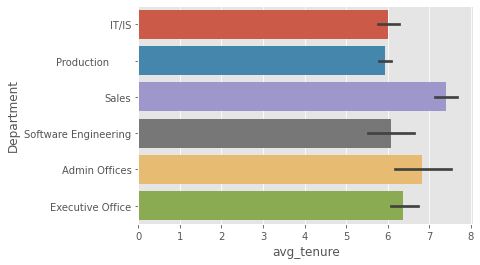

In [57]:
sns.barplot(data=hr, x='avg_tenure', y='Department');

In [58]:
hr[['avg_tenure','Department']].describe().T

,count,mean,std,min,25%,50%,75%,max
avg_tenure,3310.0,6.126285,3.313917,-0.657534,3.528767,6.463014,9.071233,14.545205


<b> Number of employees per department by gender

In [59]:
hr.groupby(['Department','GenderID'])['EmpID'].count()

Department            GenderID
Admin Offices         0             44
                      1             36
Executive Office      0              1
                      1             23
IT/IS                 0            260
                      1            265
Production            0           1385
                      1            846
Sales                 0            119
                      1            216
Software Engineering  0             49
                      1             66
Name: EmpID, dtype: int64

<b> Correlation between variables

In [60]:
hr.corr()

,EmpID,MarriedID,MaritalStatusID,GenderID,EmpStatusID,DeptID,PerfScoreID,FromDiversityJobFairID,PayRate,Termd,PositionID,Zip,EmpTotal,ManagerID,EngagementSurvey,EmpSatisfaction,SpecialProjectsCount,DaysLateLast30,avg_tenure
EmpID,1.000000,-0.001453,0.011813,0.006117,-0.023219,0.009128,0.013224,0.004270,0.011340,-0.002760,-0.006604,0.130735,0.008594,-0.014323,0.011462,0.000119,-0.006014,NaN,0.042169
MarriedID,-0.001453,1.000000,0.141627,0.035406,-0.037568,-0.115086,0.020185,0.010940,-0.011059,-0.021967,-0.041895,-0.040212,0.076962,-0.101045,-0.070152,0.035770,0.121970,NaN,0.004140
MaritalStatusID,0.011813,0.141627,1.000000,0.012091,0.002176,0.066222,0.036304,-0.047696,-0.034245,0.027610,0.007064,0.010792,0.005479,-0.025267,-0.040528,-0.022650,-0.084838,NaN,-0.030239
GenderID,0.006117,0.035406,0.012091,1.000000,-0.044155,-0.033267,0.031142,-0.006681,0.164064,-0.038501,-0.145881,0.051408,0.053025,0.018442,-0.076723,-0.006325,0.097752,NaN,-0.008129
EmpStatusID,-0.023219,-0.037568,0.002176,-0.044155,1.000000,0.125219,-0.002207,0.139685,-0.194180,0.383900,0.242752,-0.151348,-0.910375,0.204887,0.019885,-0.076292,-0.162364,NaN,-0.796843
DeptID,0.009128,-0.115086,0.066222,-0.033267,0.125219,1.000000,-0.035352,-0.031424,-0.233580,0.109852,0.005349,0.291917,-0.108582,0.482591,-0.093521,0.072753,-0.775803,NaN,0.028646
PerfScoreID,0.013224,0.020185,0.036304,0.031142,-0.002207,-0.035352,1.000000,0.014933,-0.023494,-0.062624,0.054211,-0.062361,0.019761,-0.038479,-0.058112,-0.037250,0.051694,NaN,0.030510
FromDiversityJobFairID,0.004270,0.010940,-0.047696,-0.006681,0.139685,-0.031424,0.014933,1.000000,-0.052566,0.091264,0.106533,-0.028592,-0.141485,0.122182,-0.043774,-0.053789,-0.021981,NaN,-0.024496
PayRate,0.011340,-0.011059,-0.034245,0.164064,-0.194180,-0.233580,-0.023494,-0.052566,1.000000,-0.146554,-0.415262,0.391945,0.147650,-0.387182,0.010296,-0.009209,0.489110,NaN,0.071684
Termd,-0.002760,-0.021967,0.027610,-0.038501,0.383900,0.109852,-0.062624,0.091264,-0.146554,1.000000,0.165595,-0.138353,-0.335582,0.150851,0.026878,-0.038060,-0.142804,NaN,-0.176489


<b> Employee Satisfaction

In [61]:
hr[['EmpSatisfaction','Department']].describe().T

,count,mean,std,min,25%,50%,75%,max
EmpSatisfaction,3310.0,3.890937,0.831829,1.0,3.0,4.0,5.0,5.0


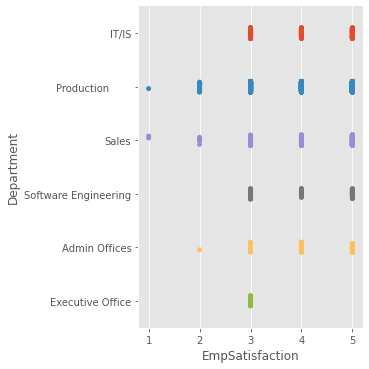

In [62]:
sns.catplot(data=hr, x='EmpSatisfaction', y='Department');

<b>Total turnover rate </b> <br> calculated by no.of employees who left divided by average no. of employees * 100%

In [63]:
hr.groupby(['EmploymentStatus'])['EmploymentStatus'].agg('count').to_frame('total')

,total
EmploymentStatus,
Active,1984
Future Start,180
Leave of Absence,187
Terminated for Cause,162
Voluntarily Terminated,797


In [64]:
emp_active=hr[hr['EmploymentStatus'].str.contains('Active')]['EmploymentStatus'].count()
emp_left=hr[hr['EmploymentStatus'].str.contains ('Terminated')]['EmploymentStatus'].count()
avg_emp=hr.groupby(['EmploymentStatus'])['EmploymentStatus'].agg('count').mean()
emp_total=hr.groupby(['EmploymentStatus'])['EmploymentStatus'].agg('count')

In [65]:
turnover_rate=(emp_left/avg_emp)*100
print (turnover_rate)

144.86404833836858


<b> Linear Regression (Employee Satisfaction vs Engagement)

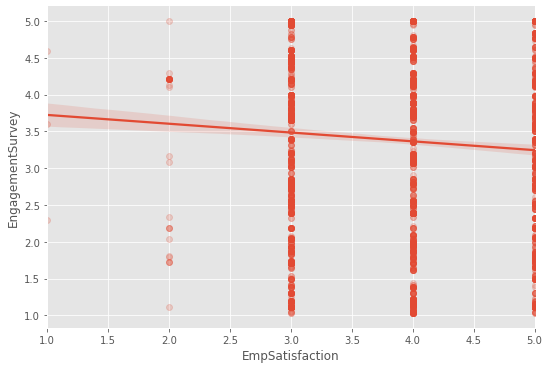

In [66]:
sns.lmplot(x='EmpSatisfaction', y='EngagementSurvey', data=hr, aspect=1.5, scatter_kws={'alpha':0.2});

This graph shows that the level of engagement decreases as employee satisfaction increase. There are cases when employees had a satisfaction score of 2 has a very high engagement score (4 to 5). 

In [67]:
feature_cols = ['EngagementSurvey']
X = hr[feature_cols]
y = hr['EmpSatisfaction']

In [68]:
lr = LinearRegression()

In [69]:
lr.fit(X, y)

LinearRegression()

In [70]:
print(lr.coef_)

[-0.05057825]


With an increase in engagement survey score of 1, the associated level of engagement decrease by -0.05.

In [71]:
print(lr.intercept_)

4.061795827697231


In [72]:
lr.predict(np.array([1]).reshape(1,-1))

array([4.01121758])

In [73]:
X_new = [[1], [2.5], [3]]
lr.predict(X_new)

array([4.01121758, 3.93535021, 3.91006109])

if the engagement survey score is 1,2.5 and 3, the corressponding associated employee satisfaction score would be 4.0 and 3.9.

<b> Download dataframes:

In [76]:
hr.to_csv('cleaned_hrdataframe.csv')

In [77]:
combined_df.to_csv('cleaned_combined_df.csv')